In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
air_passengers = pd.read_csv("AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

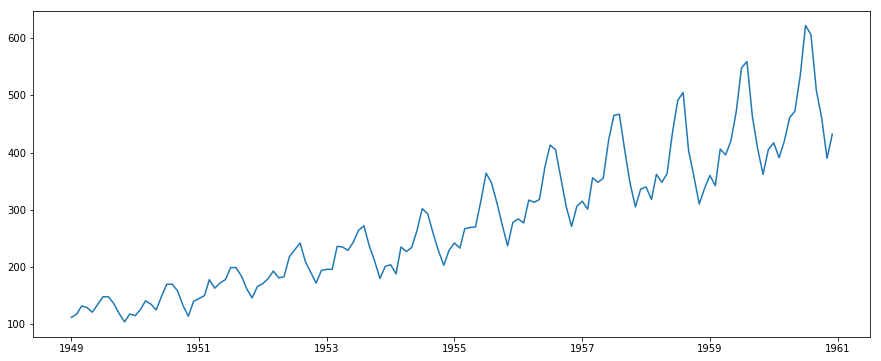

In [3]:
# Let us see the original data spread
plt.plot(air_passengers.Passengers)

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\tsa\filters\filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


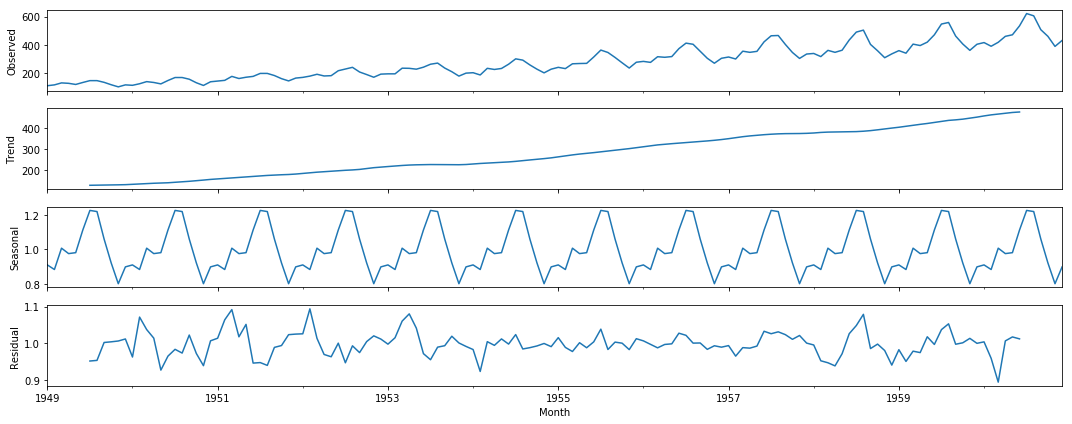

In [4]:
decomposition = seasonal_decompose(air_passengers.Passengers, model = "multiplicative")
decomposition.plot()
plt.show()

In [5]:
log_air_passengers = np.log(air_passengers.Passengers)
log_air_passengers[1:10]

Month
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
1949-06-01    4.905275
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.912655
1949-10-01    4.779123
Name: Passengers, dtype: float64

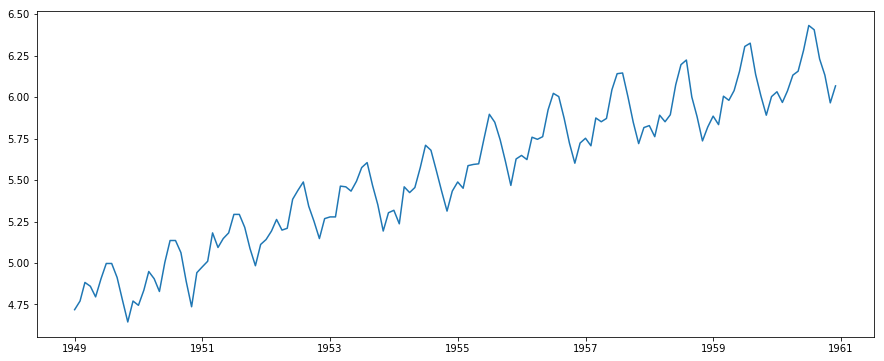

In [6]:
# Data after log normalizing - Constant variance
plt.plot(log_air_passengers)

In [7]:
log_air_passengers_diff = log_air_passengers - log_air_passengers.shift()

In [8]:
log_air_passengers_diff.dropna(inplace=True)
log_air_passengers_diff[1:10]

Month
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
1949-07-01    0.091937
1949-08-01    0.000000
1949-09-01   -0.084557
1949-10-01   -0.133531
1949-11-01   -0.134733
Name: Passengers, dtype: float64

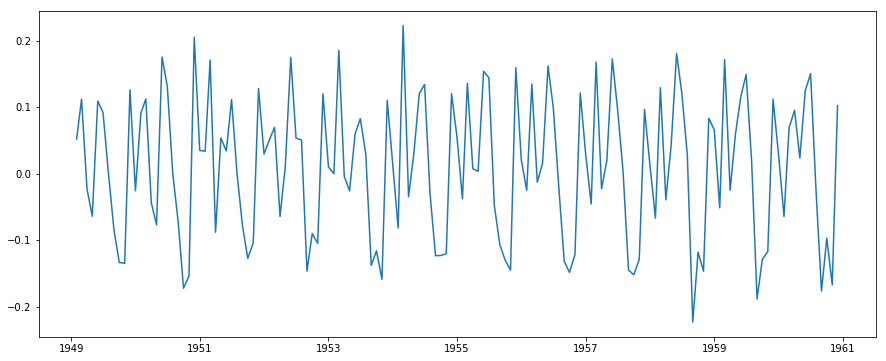

In [9]:
# Data after log normalizing & 1st order differencing- Constant variance & mean - Removal of trend
plt.plot(log_air_passengers_diff)

In [10]:
# Try what you could get when you do 2nd order differencing

#log_air_passengers_diff2 = log_air_passengers_diff - log_air_passengers_diff.shift()
#log_air_passengers_diff2.dropna(inplace=True)
#plt.plot(log_air_passengers_diff2)

# 1. Do the DF Test for stationarity
# 2. Check the q & p values from ACF and PACF respectively
# 3. Apply ARIMA(p,d,q)
# 4. Forecast and check if its better or worse

There are two ways to check the stationarity of a time series. The first is plot the moving variance and observe if it remains constant over time. However, you might not always be able to make such visual inferences. The second way is to use the **Dickey-Fuller test**, a statistical test with the null hypothesis that the **time series is non-stationary**.

_**If the test results in the test statistic significantly less than the critical values, we can reject the null hypothesis in favor of time series stationarity.**_

In [14]:
from statsmodels.tsa.stattools import adfuller


In [15]:

#ceating a function to test wheather the time series is stationary or not
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean() 
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

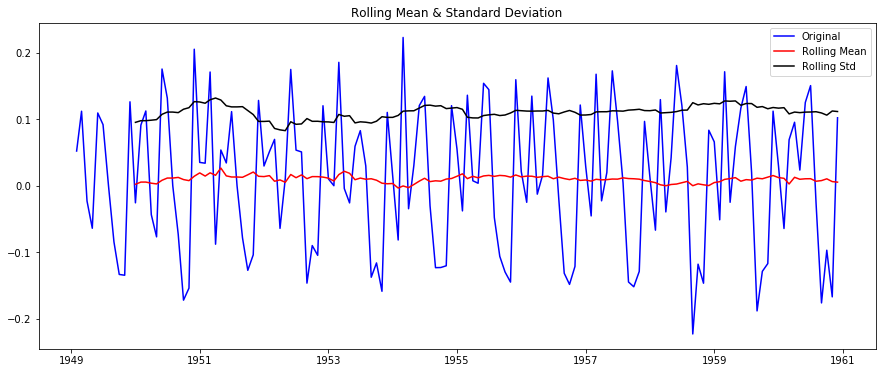

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (5%)             -2.884398
Critical Value (1%)             -3.482501
Critical Value (10%)            -2.578960
dtype: float64


In [16]:
test_stationarity(log_air_passengers_diff)

In [13]:
# Let's talk about the ARIMA model
# Auto-Regressive Integrated Moving Average
# In this case we're talking about a series with dependence among values (more natural)

In [17]:
# Nothing but a linear regression with a few times
# 1. The number of Auto-Regressive Terms (p)
# 2. The number of Moving Average Terms (q)
# 3. The number of differences taken

In [18]:
# We don't pull these out of thin air, but rather draw them from the data
from statsmodels.tsa.stattools import adfuller, acf, pacf
lag_acf = acf(log_air_passengers_diff.values, nlags = 20)
lag_pacf = pacf(log_air_passengers_diff.values, nlags = 20)

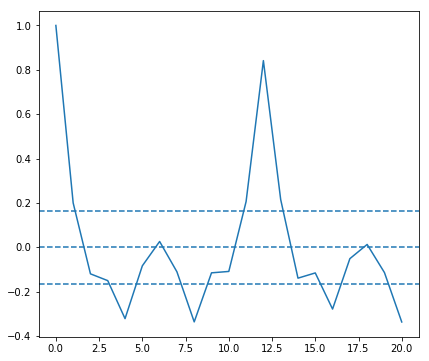

In [19]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [20]:
# look at where the plot passes the upper confidence interval for the first time
# for ACF this is 2 and gives us the q value

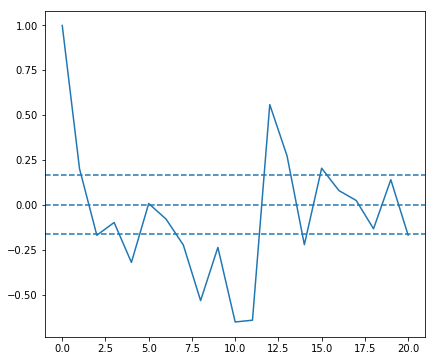

In [21]:
plt.subplot(121) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--')
plt.axhline(y=-1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')
plt.axhline(y=1.96/np.sqrt(len(log_air_passengers_diff)),linestyle='--')

In [22]:
# look at where the plot passes the upper confidence interval for the first time
# for PACF this is 2 and gives us the p value

In [23]:
from statsmodels.tsa.arima_model import ARIMA

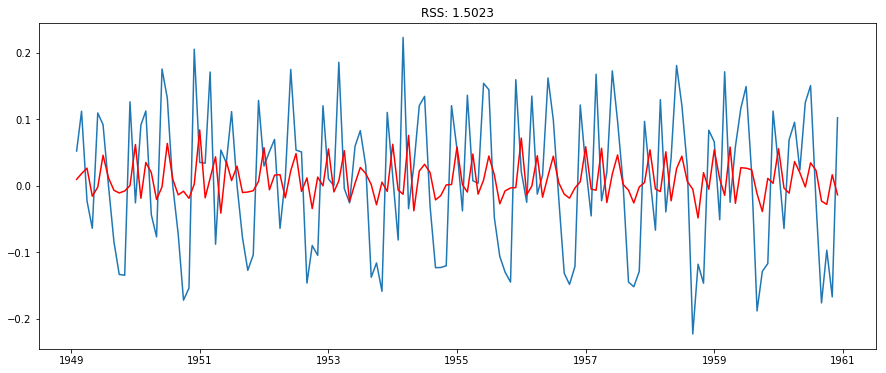

In [24]:
# AR model
model = ARIMA(log_air_passengers, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-log_air_passengers_diff)**2))

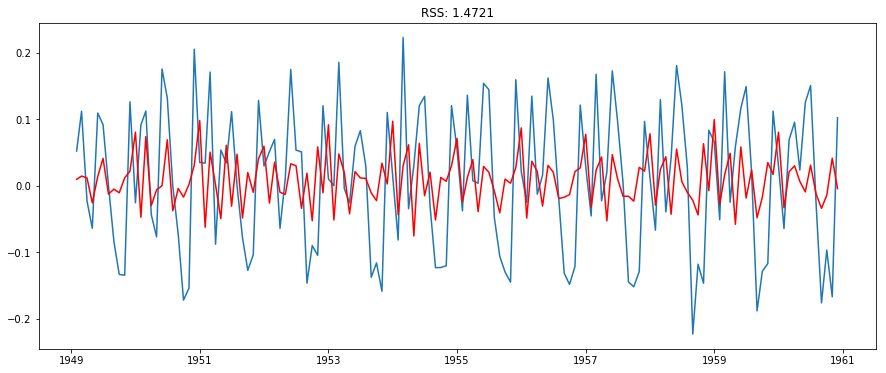

In [25]:
# MA model
model = ARIMA(log_air_passengers, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-log_air_passengers_diff)**2))

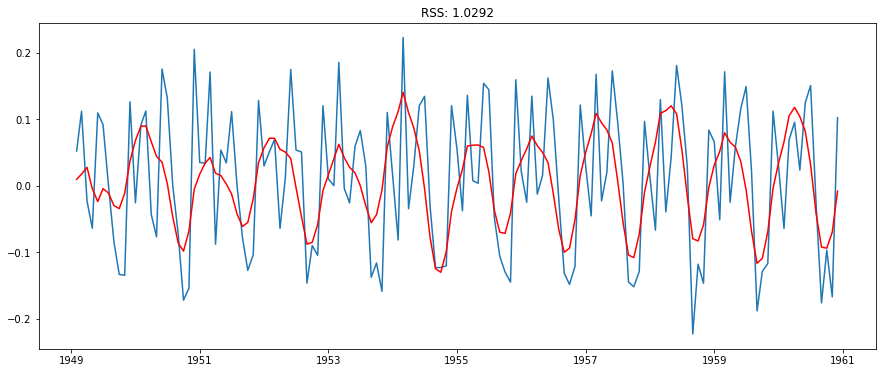

In [26]:
# ARIMA model
model = ARIMA(log_air_passengers, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_air_passengers_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-log_air_passengers_diff)**2))

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64


In [28]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [29]:
predictions_ARIMA_log = pd.Series(log_air_passengers.ix[0], index=log_air_passengers.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773240
1949-05-01    4.768720
dtype: float64

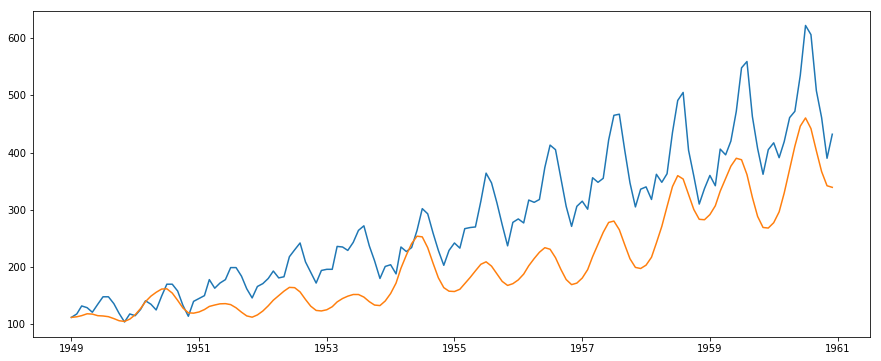

In [30]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(air_passengers)
plt.plot(predictions_ARIMA)